# Import Packages

In [1]:
import itertools
import joblib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from dython.nominal import associations

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 1000)

# Data Preparation

In [2]:
csv_filename = "loan_data_2007_2014.csv"
feather_filename = "loan_data_2007_2014.feather"

## Data Reading
Read data with `.csv` file, and save into `.feather` file

In [3]:
if not os.path.exists(feather_filename):
    # Read csv file
    df = pd.read_csv("loan_data_2007_2014.csv")

    # change to feather
    df.to_feather("loan_data_2007_2014.feather")

## Move to Feather Extension
For fastest reading the data

In [4]:
raw_df = pd.read_feather(feather_filename)

## Data Overview


In [5]:
raw_df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,None,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,None,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,None,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,None,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,None,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,None,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>",other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,None,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075358,"Borrower added on 12/21/11 > I plan on combining three large interest bills togethe

# Data Description

In [13]:
data_dict = pd.read_excel("LCDataDictionary1.xlsx", sheet_name="LoanStats")

## Description

In [14]:
data_dict[["Colomn", "Description"]]

,Colomn,Description
0,_rec,The total amount committed by investors for that loan at that point in time.
1,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,collection_recovery_fee,post charge off collection fee
8,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
9,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years


## DataFrame Check

In [15]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# EDA

In [16]:
title_font = dict(size=20, weight="bold")

def plot_count(df, y, title, **sns_kwargs):
    value_counts = df[y].value_counts()
    percentage = value_counts / value_counts.sum()
    percentage = percentage.apply("{:.2%}".format)

    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.countplot(data=df, y=y, order=value_counts.index, **sns_kwargs)
    plt.ylabel("")
    plt.show()

    print(percentage)


def plot_distribution(df, x, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.histplot(data=df, x=x, kde=True, **sns_kwargs)
    plt.ylabel("")
    plt.show()


def plot_boxplot(df, x, y, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.boxplot(data=df, x=x, y=y, **sns_kwargs)
    plt.ylabel("")
    plt.show()

## Loan Status
Most loans are in an "on going" status. At the success rate, loans that are successfully repaid have a higher ratio than loans that are overdue.

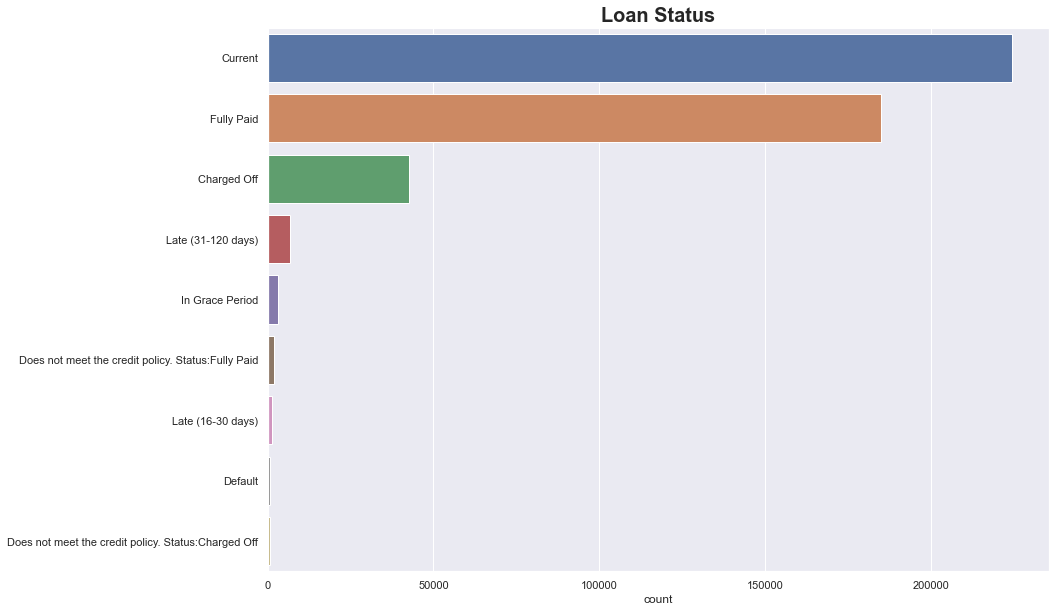

Current                                                48.09%
Fully Paid                                             39.62%
Charged Off                                             9.11%
Late (31-120 days)                                      1.48%
In Grace Period                                         0.67%
Does not meet the credit policy. Status:Fully Paid      0.43%
Late (16-30 days)                                       0.26%
Default                                                 0.18%
Does not meet the credit policy. Status:Charged Off     0.16%
Name: loan_status, dtype: object


In [84]:
plot_count(raw_df, title="Loan Status",  y="loan_status")

## Determining Loan Status
Our goal here is to determine which loans are likely to default, so that the categories we can take are between those that are successful and those that fail. Therefore we will only take 2 categories namely:
- Approved, consisting of: Fully Paid
- Rejected, consisting of: Charged Off, Default, and Does not meet the credit policy

We can't use `current` because the loan is still ongoing, as well as `late` and `in_grace_period`.

In [85]:
# Decide which category to use
approved_cat = ["Fully Paid"]
dissaproved_cat = [
    
    "Charged Off",
    "Default",
    "Does not meet the credit policy. Status:Fully Paid",
    "Does not meet the credit policy. Status:Charged Off"
]

In [86]:
# change to a new label
def label_loan_status(value):
    if value in approved_cat:
        return 1
    return 0

label_loan_status("Fully Paid")

1

In [87]:
# Filter and apply function
inter_df = raw_df[raw_df["loan_status"].isin(approved_cat + dissaproved_cat)].copy()
inter_df["loan_status"] = inter_df["loan_status"].apply(label_loan_status)

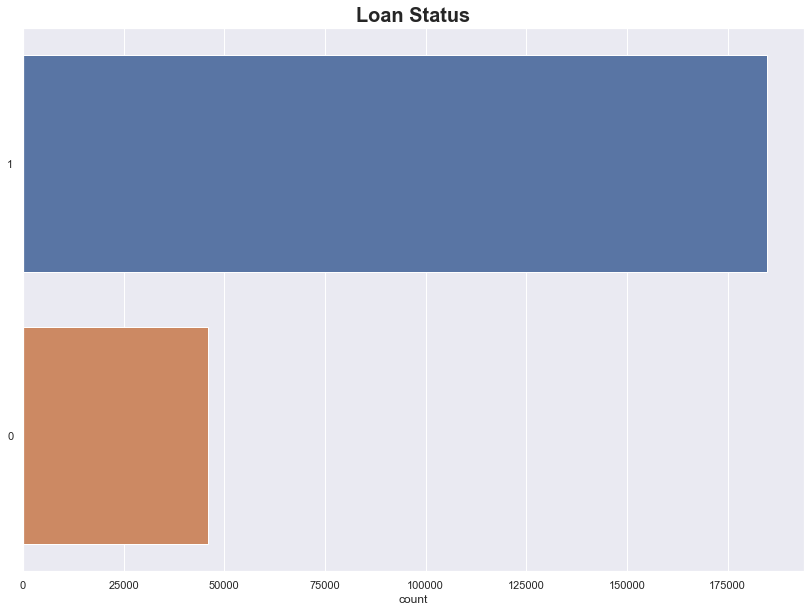

1    80.04%
0    19.96%
Name: loan_status, dtype: object


In [88]:
plot_count(inter_df, y="loan_status", title="Loan Status")

## Correlation between Variables

In [89]:
# Calculate the correlation each variables
correlations = (inter_df.select_dtypes(exclude=object)
                         .corr()
                         .dropna(how="all", axis=0)
                         .dropna(how="all", axis=1)
)

In [23]:
correlations["loan_status"].abs().sort_values(ascending=False)

loan_status                    1.000000
total_rec_prncp                0.460338
recoveries                     0.445422
last_pymnt_amnt                0.384781
total_pymnt_inv                0.358588
total_pymnt                    0.355349
collection_recovery_fee        0.300094
int_rate                       0.241059
total_rec_late_fee             0.152231
inq_last_6mths                 0.116393
dti                            0.107257
out_prncp                      0.099816
out_prncp_inv                  0.099814
revol_util                     0.089180
tot_cur_bal                    0.076230
mths_since_last_record         0.062190
annual_inc                     0.061623
total_rev_hi_lim               0.052931
loan_amnt                      0.049253
funded_amnt                    0.048790
funded_amnt_inv                0.039854
installment                    0.033419
total_rec_int                  0.032997
total_acc                      0.030680
mths_since_last_delinq         0.029299


In [90]:
# Filter correlation between vmin - vmax
vmin, vmax = 0.1, 0.99

unstack_corr = correlations.unstack()
pos_corr = (unstack_corr > vmin) & (unstack_corr < vmax)
neg_corr = (unstack_corr > -vmax) & (unstack_corr < -vmin)
high_corr = unstack_corr[pos_corr | neg_corr]

trimmed_corr = high_corr.sort_values(ascending=False).unstack()

In [91]:
# Create a mask to form the lower triangular matrix
mask = np.zeros_like(trimmed_corr)
mask[np.triu_indices_from(mask)] = True

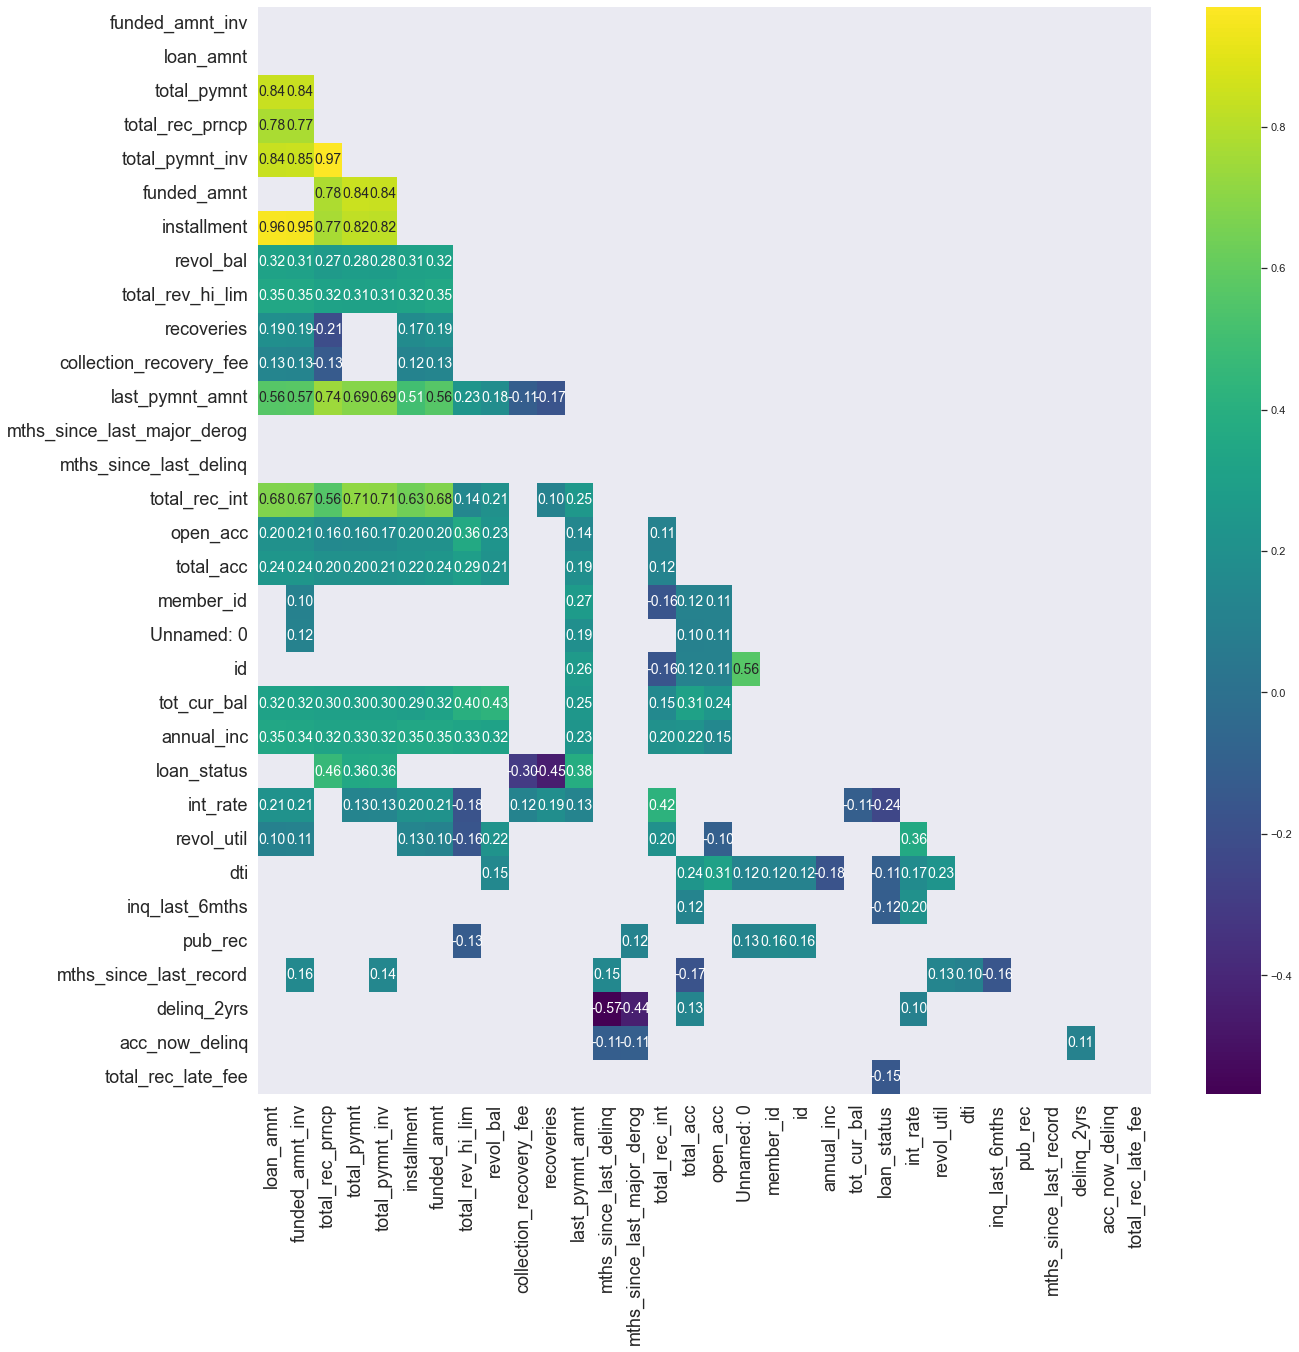

In [92]:
# Show heatmap
plt.figure(figsize=(20, 20))
plot = sns.heatmap(
    trimmed_corr, 
    annot=True, 
    mask=mask,
    fmt=".2f", 
    cmap="viridis", 
    annot_kws={"size": 14})

plot.set_xticklabels(plot.get_xticklabels(), size=18)
plot.set_yticklabels(plot.get_yticklabels(), size=18)
plt.show()

From the heatmap above, there are several variables that have an influence on loan status, including:

In [27]:
affect_loan = high_corr.loc["loan_status"].abs().sort_values(ascending=False)
affect_loan

total_rec_prncp            0.460338
recoveries                 0.445422
last_pymnt_amnt            0.384781
total_pymnt_inv            0.358588
total_pymnt                0.355349
collection_recovery_fee    0.300094
int_rate                   0.241059
total_rec_late_fee         0.152231
inq_last_6mths             0.116393
dti                        0.107257
dtype: float64

While the features that are correlated with the previous one we need to identify. We use a limit value of 0.9 to look for features that are strongly correlated.

In [28]:
threshold = 0.9
affect_collision = (high_corr.abs()
                             .loc[high_corr > threshold]
                             .loc[affect_loan.index, affect_loan.index]
                             .sort_values(ascending=False)
)
affect_collision

total_rec_prncp  total_pymnt        0.975030
total_pymnt      total_rec_prncp    0.975030
total_rec_prncp  total_pymnt_inv    0.969473
total_pymnt_inv  total_rec_prncp    0.969473
dtype: float64

Based on the magnitude of its influence on the loan status, the correlated features will be selected based on the most influential.

In [29]:
left_index = affect_collision.index.get_level_values(0)
right_index = affect_collision.index.get_level_values(1)

def remove_collide_index(left_index, right_index):
    include, exclude = [], []

    for left, right in zip(left_index, right_index):
        if left not in include and left not in exclude:
            include.append(left)
        if right not in include and right not in exclude:
            exclude.append(right)
        
    return include, exclude


include_affect_col, exclude_affect_col = remove_collide_index(left_index, right_index)
include_affect_col, exclude_affect_col

(['total_rec_prncp'], ['total_pymnt', 'total_pymnt_inv'])

Influential numeric features that we will use

In [30]:
affect_num_cols = affect_loan[~affect_loan.index.isin(exclude_affect_col)].index.to_list()
affect_num_cols

['total_rec_prncp',
 'recoveries',
 'last_pymnt_amnt',
 'collection_recovery_fee',
 'int_rate',
 'total_rec_late_fee',
 'inq_last_6mths',
 'dti']

## Loan Status and Principal Loan Size Paid
Principal is the amount of the principal loan lent to the debtor. In other words, it is the original amount of money lent. Most people who experience default have not been able to pay the principal payment until maturity, it can be seen from the distribution of payments below. The average is almost 0.

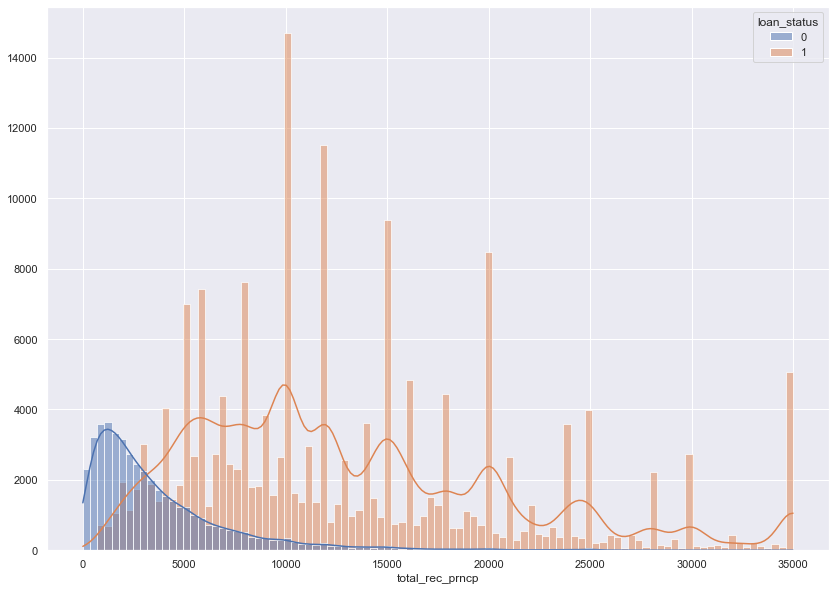

In [32]:
plot_distribution(df=inter_df, x="total_rec_prncp", hue="loan_status", title="")

## Loan Status and Total Unbilled Money
Charged off recoveries are the total money that cannot be paid to the borrowing company because the maturity period has passed so that the borrowing company can release the right to collect the debt by selling it to another company. From this it is clear that it is people with bad loan status who have the most charge off recoveries.

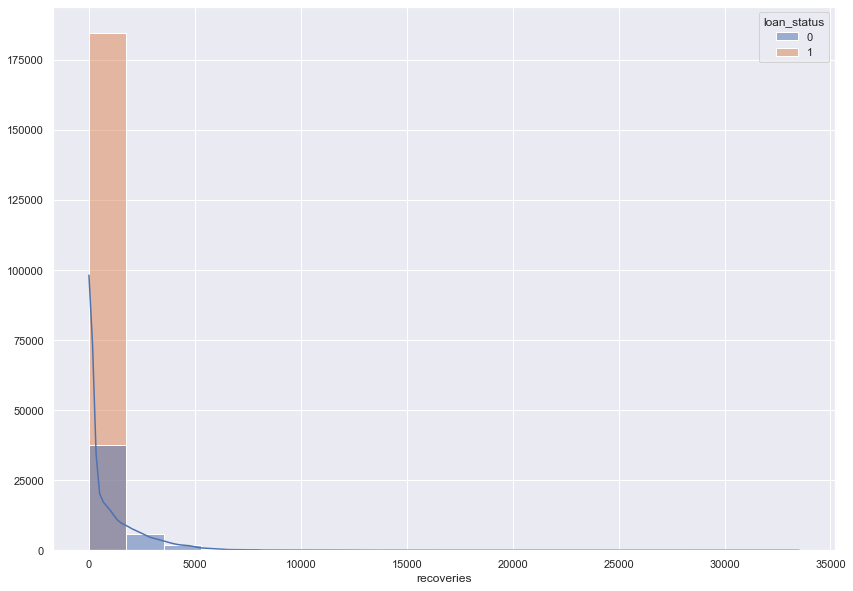

In [33]:
plot_distribution(df=inter_df, x="recoveries", hue="loan_status", title="")

## Loan Status and Loan Amount
The average loan amount is in the 'bad' status.

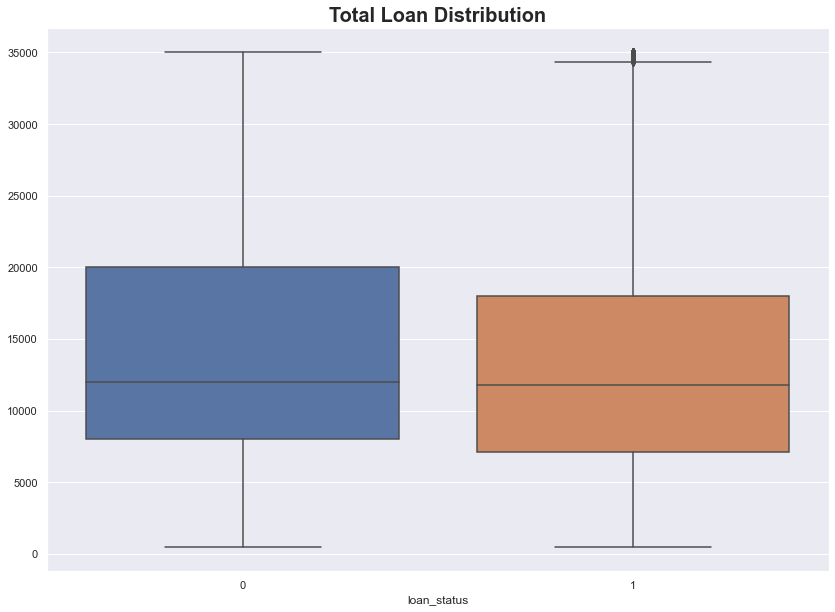

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,46056.0,14205.570393,8362.468087,500.0,8000.0,12000.0,20000.0,35000.0
1,184739.0,13214.394226,7949.030252,500.0,7125.0,11800.0,18000.0,35000.0


In [93]:
x, y = "loan_status", "loan_amnt"
plot_boxplot(df=inter_df, x=x, y=y, title="Total Loan Distribution")
inter_df.groupby(x)[y].describe()

## Loan Status and Total Payments Received
It is clear that the highest total payments are on loans with 'good' status.

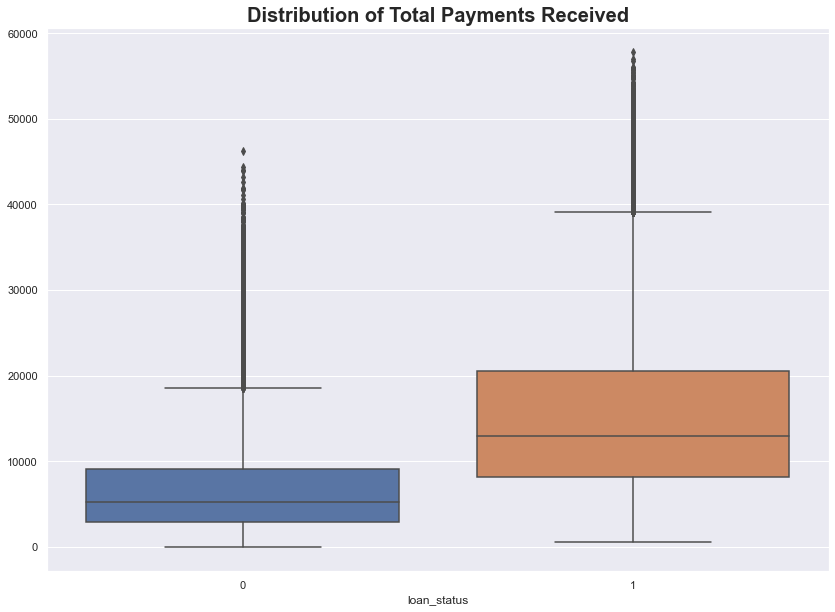

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,46056.0,6814.461231,5610.294962,0.00,2829.912500,5260.94000,9120.685,46199.44000
1,184739.0,15209.872007,9459.142043,526.33,8092.460697,12979.34106,20491.905,57777.57987


In [94]:
x, y = "loan_status", "total_pymnt"
plot_boxplot(df=inter_df, x=x, y=y, title="Distribution of Total Payments Received")
inter_df.groupby(x)[y].describe()

## Purpose of Taking a Loan
More than half of borrowers have a goal of closing previous loans. When viewed from the type, the purpose for consumption is more than the purpose for business, renovation and education.

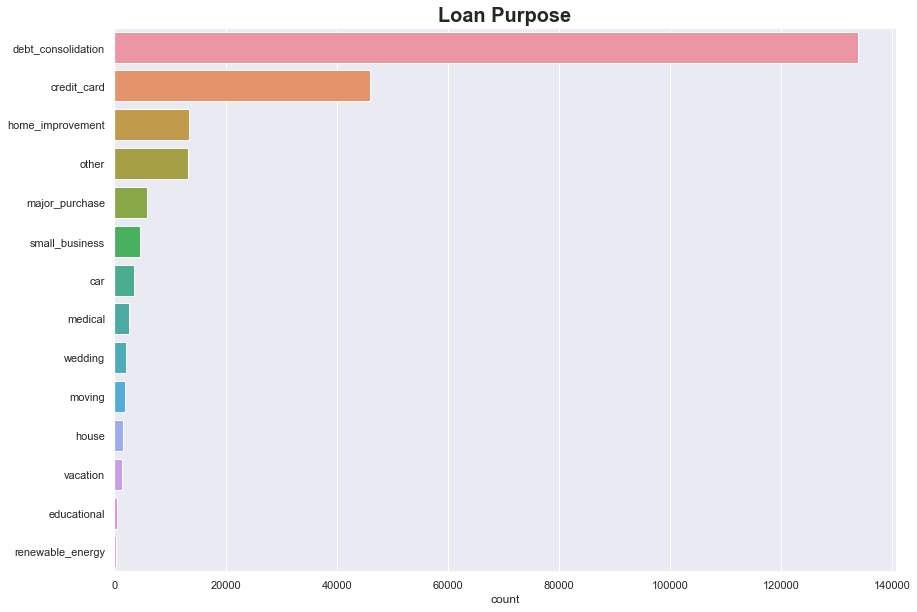

debt_consolidation    58.03%
credit_card           19.95%
home_improvement       5.83%
other                  5.76%
major_purchase         2.54%
small_business         2.02%
car                    1.50%
medical                1.15%
wedding                0.87%
moving                 0.80%
house                  0.65%
vacation               0.62%
educational            0.18%
renewable_energy       0.11%
Name: purpose, dtype: object


In [95]:
plot_count(inter_df, y="purpose", title="Loan Purpose")

## Borrower's Country of Origin
Most of the borrowers come from California.


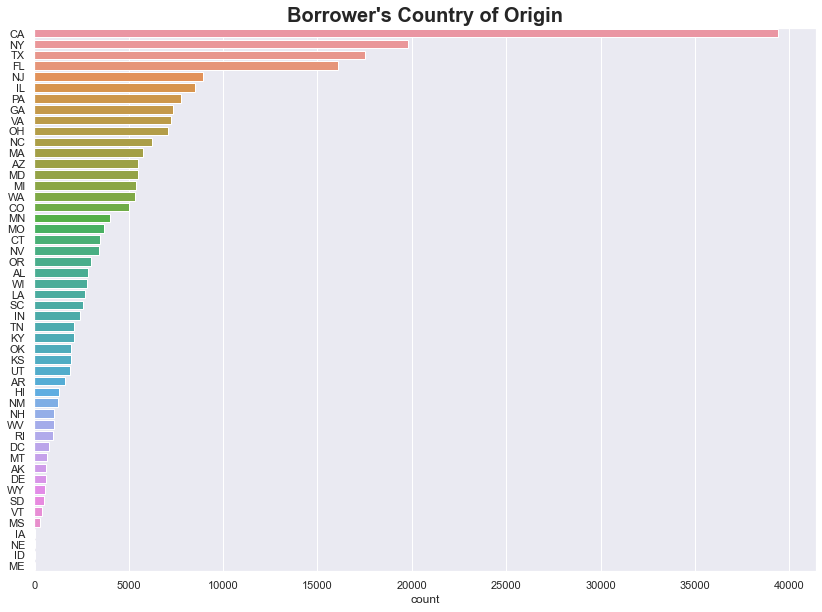

CA    17.08%
NY     8.58%
TX     7.60%
FL     6.96%
NJ     3.87%
IL     3.70%
PA     3.36%
GA     3.17%
VA     3.14%
OH     3.06%
NC     2.69%
MA     2.48%
AZ     2.38%
MD     2.37%
MI     2.33%
WA     2.32%
CO     2.18%
MN     1.73%
MO     1.59%
CT     1.50%
NV     1.49%
OR     1.31%
AL     1.24%
WI     1.21%
LA     1.16%
SC     1.11%
IN     1.04%
TN     0.91%
KY     0.90%
OK     0.84%
KS     0.83%
UT     0.82%
AR     0.70%
HI     0.57%
NM     0.54%
NH     0.46%
WV     0.45%
RI     0.43%
DC     0.34%
MT     0.29%
AK     0.27%
DE     0.26%
WY     0.24%
SD     0.21%
VT     0.17%
MS     0.13%
IA     0.01%
NE     0.01%
ID     0.00%
ME     0.00%
Name: addr_state, dtype: object


In [96]:
plot_count(df=inter_df, y="addr_state", title="Borrower's Country of Origin")

## Loan Rate
Loans are graded from the letters of the alphabet A to G, the closer to G the higher the interest rate paid.

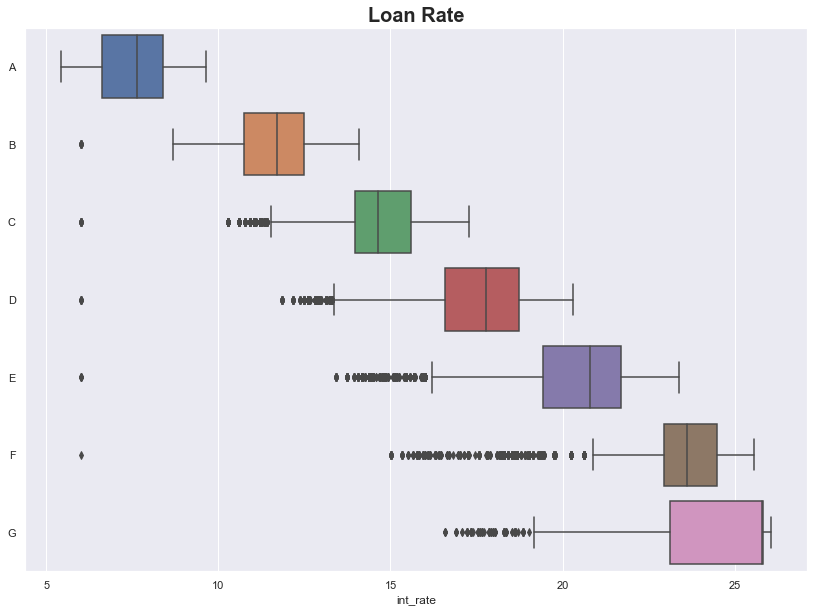

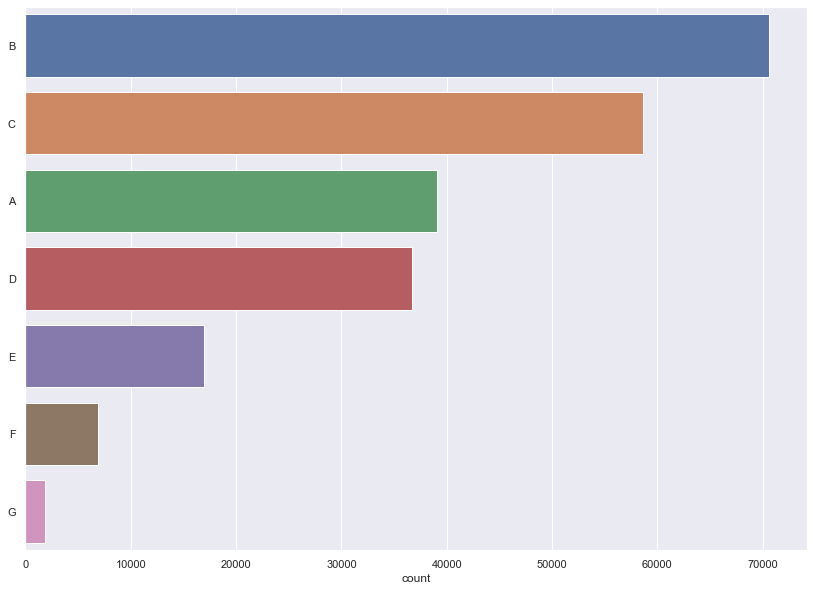

B    30.60%
C    25.40%
A    16.95%
D    15.92%
E     7.34%
F     2.99%
G     0.80%
Name: grade, dtype: object


,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
A,39110.0,7.545742,1.003571,5.42,6.62,7.62,8.39,9.63
B,70622.0,11.654616,1.281087,6.00,10.74,11.71,12.49,14.09
C,58626.0,14.767515,1.233598,6.00,13.98,14.64,15.61,17.27
D,36740.0,17.628885,1.484771,6.00,16.59,17.77,18.75,20.31
E,16945.0,20.341001,1.920465,6.00,19.42,20.80,21.70,23.40
F,6896.0,23.137195,2.097052,6.00,22.95,23.63,24.50,25.57
G,1856.0,24.191482,2.509841,16.59,23.13,25.80,25.83,26.06


In [97]:
x, y = "int_rate", "grade"
order = inter_df[y].sort_values().unique()
plot_boxplot(inter_df, x=x, y=y, title="Loan Rate", order=order)
plot_count(df=inter_df, y=y, title="")
inter_df.groupby(y)[x].describe()

## Home Ownership Status
Most of the borrowers delegate their house as collateral for the loan, while only a few of the borrowers own their own house.

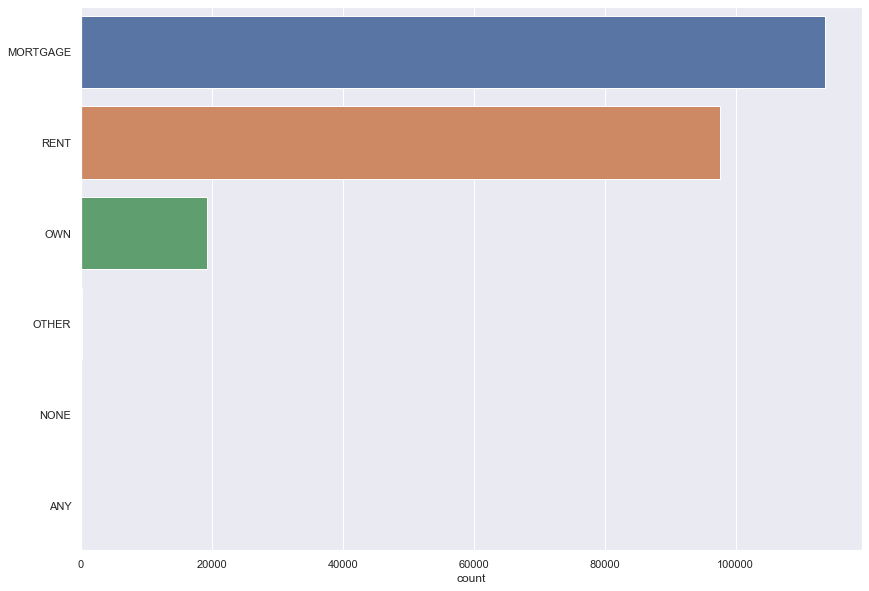

MORTGAGE    49.23%
RENT        42.29%
OWN          8.38%
OTHER        0.08%
NONE         0.02%
ANY          0.00%
Name: home_ownership, dtype: object


In [39]:
y = "home_ownership"
order = inter_df[y].sort_values().unique()
plot_count(df=inter_df, y=y, title="")

# Data Preprocessing

## Eliminate unused features
After seeing the info and description of the data above, there are features that we don't need to use because they are not so significant to be used as features in predictions.

In [98]:
# Detailed information about data columns and rows
data_stat = pd.DataFrame()
data_stat.index = inter_df.columns
data_stat["unique_value"] = inter_df.nunique()
data_stat["missing_rate"] = inter_df.isna().mean()
data_stat["dtype"] = inter_df.dtypes
data_stat

,unique_value,missing_rate,dtype
Unnamed: 0,230795,0.000000,int64
id,230795,0.000000,int64
member_id,230795,0.000000,int64
loan_amnt,1308,0.000000,int64
funded_amnt,1311,0.000000,int64
funded_amnt_inv,9552,0.000000,float64
term,2,0.000000,object
int_rate,505,0.000000,float64
installment,43071,0.000000,float64
grade,7,0.000000,object


Column with unusable data

In [99]:
# Column where all data is missing
miss_col = data_stat[data_stat["missing_rate"] == 1].index.to_list()
print("Column where all data is missing:")
print(miss_col)
print()

# Column where all data is very unique
vari_col = data_stat[data_stat["unique_value"] == inter_df.shape[0]].index.to_list()
print("Column where all data is very unique:")
print(vari_col)
print()

# Column with many categorizes
cat_col_stat = data_stat[data_stat["dtype"] == "object"]
vari_cat_col = cat_col_stat[cat_col_stat["unique_value"] > 1000].index.to_list()
print("Column with many categorizes:")
print(vari_cat_col)
print()

# Column with only one value
single_valued_col = data_stat[data_stat["unique_value"] == 1].index.to_list()
print("Column with only one value:")
print(single_valued_col)
print()

removed_features = miss_col + vari_col + vari_cat_col + single_valued_col

Column where all data is missing:
['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']

Column where all data is very unique:
['Unnamed: 0', 'id', 'member_id', 'url']

Column with many categorizes:
['emp_title', 'url', 'desc', 'title']

Column with only one value:
['policy_code', 'application_type']



In [100]:
# Delete Unused Features
pre_df = inter_df.loc[:, ~inter_df.columns.isin(removed_features)].copy()
pre_df.shape

(230795, 49)

## Categorical or object Features

In [101]:
# Column with object or categorical value
cat_features = pre_df.select_dtypes(include=object).columns
cat_features

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d'],
      dtype='object')

### Column with a date value

In [44]:
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"]

for col in date_cols:
    print(pre_df[col].value_counts().iloc[:5])
    print()

Oct-14    8808
Jul-14    8614
Apr-14    6744
Nov-13    6665
Oct-13    6653
Name: issue_d, dtype: int64

Oct-00    1972
Oct-99    1837
Nov-00    1796
Oct-01    1779
Aug-00    1758
Name: earliest_cr_line, dtype: int64

Jul-15    11703
Mar-15    10087
Jun-15    10078
Apr-15    10051
Aug-15     9932
Name: last_pymnt_d, dtype: int64

Jan-16    93758
Dec-15    13753
Nov-15     8199
Sep-15     7942
Oct-15     7805
Name: last_credit_pull_d, dtype: int64

Feb-16    795
Mar-11    107
Apr-11    101
Feb-11     91
Jan-11     79
Name: next_pymnt_d, dtype: int64



There is no strong correlation between dates and each date has little correlation with loan status. However, we will remove the date feature that correlates less than 0.1 with the loan status

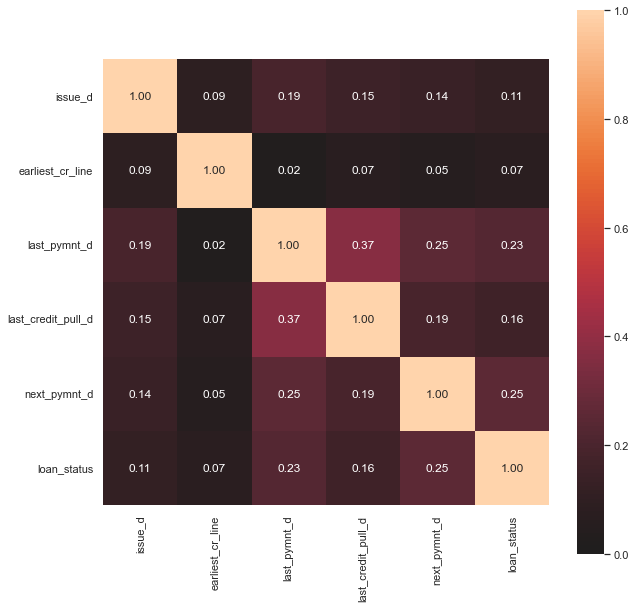

In [102]:
# Correlation between dates and loan status
used_cols = date_cols + ["loan_status"] 
complete_correlation = associations(
    pre_df[used_cols], 
    filename='date_correlation.png',
    figsize=(10,10)
)

In [104]:
# Date's features or column that we will use
affect_date_cols = ["issue_d", "last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"]
affect_date_cols

['issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'next_pymnt_d']

In [105]:
# Delete date's colum or features where does'nt have a powerfull correlation with loan status
unused_cols = ["earliest_cr_line"]
pre_df = pre_df.drop(columns=unused_cols, errors="ignore")
pre_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,Dec-11,1,n,credit_card,860xx,AZ,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,Dec-11,0,n,car,309xx,GA,1.00,0.0,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,None,Sep-13,0.0,NaN,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,Dec-11,1,n,small_business,606xx,IL,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,Dec-11,1,n,other,917xx,CA,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,None,Jan-15,0.0,NaN,0.0,NaN,NaN,NaN
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,36000.0,Source Verified,Dec-11,1,n,wedding,852xx,AZ,11.20,0.0,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,Jan-15,161.03,None,Sep-15,0.0,NaN,0.0,NaN,NaN,NaN


### Unused Categorical Columns

In [48]:
other_cat_cols = cat_features[~cat_features.isin(date_cols)]
other_cat_cols

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'initial_list_status'],
      dtype='object')

In [49]:
pre_df.loc[:, other_cat_cols].head()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose,zip_code,addr_state,initial_list_status
0,36 months,B,B2,10+ years,RENT,Verified,n,credit_card,860xx,AZ,f
1,60 months,C,C4,< 1 year,RENT,Source Verified,n,car,309xx,GA,f
2,36 months,C,C5,10+ years,RENT,Not Verified,n,small_business,606xx,IL,f
3,36 months,C,C1,10+ years,RENT,Source Verified,n,other,917xx,CA,f
5,36 months,A,A4,3 years,RENT,Source Verified,n,wedding,852xx,AZ,f


Some unused categorical columns are:
- desc and title because they are text.
- zip_code because the 3 digits behind it are censored
- sub_grade because it already has a similar column, namely grade

In [50]:
unused_cols = ["desc", "zip_code", "sub_grade", "title"]
pre_df = pre_df.drop(columns=unused_cols, errors="ignore")
pre_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-11,1,n,credit_card,AZ,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-11,0,n,car,GA,1.00,0.0,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,None,Sep-13,0.0,NaN,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-11,1,n,small_business,IL,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Dec-11,1,n,other,CA,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,None,Jan-15,0.0,NaN,0.0,NaN,NaN,NaN
5,5000,5000,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.0,Source Verified,Dec-11,1,n,wedding,AZ,11.20,0.0,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,Jan-15,161.03,None,Sep-15,0.0,NaN,0.0,NaN,NaN,NaN


In [51]:
other_cat_cols = cat_features[~cat_features.isin(date_cols + unused_cols)]
other_cat_cols

Index(['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
       'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status'],
      dtype='object')

There is a strong correlation between emp_title and loan status, followed by grade and term. Other less influential features will not be used for predictions.

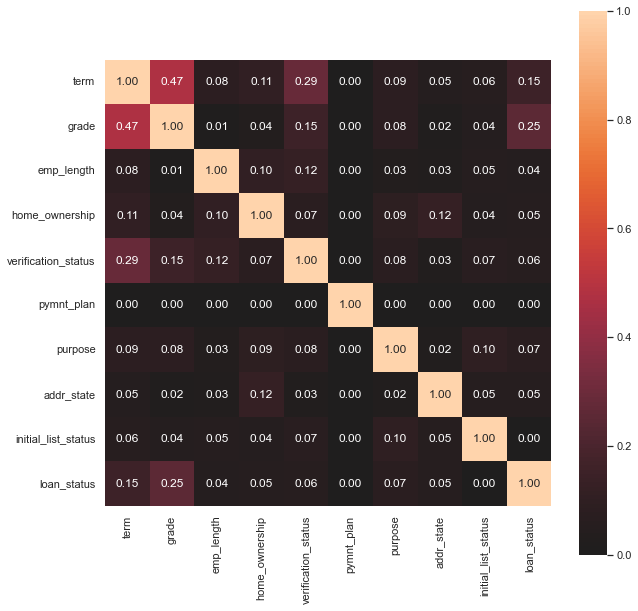

In [106]:
# Correlation between categorical features and loan status
used_cols = other_cat_cols.to_list() + ["loan_status"]
complete_correlation = associations(
    pre_df[used_cols], 
    filename='cat_correlation.png',
    figsize=(10,10)
)

The grade and term features have little correlation with the loan status.

In [107]:
#Categorical features we will use
affect_cat_cols = ["grade", "term"]
affect_cat_cols

['grade', 'term']

In [108]:
# Remove less influential features
used_cols = ["emp_title", "grade", "term"]
unused_cols = other_cat_cols[~other_cat_cols.isin(used_cols)]
pre_df = pre_df.drop(columns=unused_cols, errors="ignore")
pre_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,annual_inc,issue_d,loan_status,zip_code,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,24000.0,Dec-11,1,860xx,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,30000.0,Dec-11,0,309xx,1.00,0.0,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,None,Sep-13,0.0,NaN,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,12252.0,Dec-11,1,606xx,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,49200.0,Dec-11,1,917xx,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,None,Jan-15,0.0,NaN,0.0,NaN,NaN,NaN
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,36000.0,Dec-11,1,852xx,11.20,0.0,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,Jan-15,161.03,None,Sep-15,0.0,NaN,0.0,NaN,NaN,NaN


## Target correlated features

In [109]:
# The columns we will use
predictor_cols = affect_num_cols + affect_cat_cols + affect_date_cols
predictor_cols

['total_rec_prncp',
 'recoveries',
 'last_pymnt_amnt',
 'collection_recovery_fee',
 'int_rate',
 'total_rec_late_fee',
 'inq_last_6mths',
 'dti',
 'grade',
 'term',
 'issue_d',
 'last_pymnt_d',
 'last_credit_pull_d',
 'next_pymnt_d']

## Imputation Missing Value
The next_pyment_d feature has the most missing value because it is possible that borrowers who have paid off their debts will no longer have a repayment schedule.

In [56]:
pre_df[predictor_cols].isna().mean().sort_values(ascending=False)

next_pymnt_d               0.984484
last_pymnt_d               0.001629
inq_last_6mths             0.000126
last_credit_pull_d         0.000100
total_rec_prncp            0.000000
recoveries                 0.000000
last_pymnt_amnt            0.000000
collection_recovery_fee    0.000000
int_rate                   0.000000
total_rec_late_fee         0.000000
dti                        0.000000
grade                      0.000000
term                       0.000000
issue_d                    0.000000
dtype: float64

In [110]:
# Fill data with "no"
pre_df["next_pymnt_d"] = pre_df["next_pymnt_d"].fillna("no")
top_next_pyment_d = pre_df["next_pymnt_d"].value_counts().head()
top_next_pyment_d

no        227214
Feb-16       795
Mar-11       107
Apr-11       101
Feb-11        91
Name: next_pymnt_d, dtype: int64

Do the same for the last_pymnt_d and last_credit_pull_d columns

In [58]:
pre_df["last_pymnt_d"] = pre_df["last_pymnt_d"].fillna("no")
pre_df["last_credit_pull_d"] = pre_df["last_credit_pull_d"].fillna("no")

Fill in missing value numeric data using mode value

In [59]:
mode = pre_df["inq_last_6mths"].mode().values[0]
pre_df["inq_last_6mths"] = pre_df["inq_last_6mths"].fillna(mode)

Check again if there is still missing data

In [60]:
pre_df[predictor_cols].isna().mean().sort_values(ascending=False)

total_rec_prncp            0.0
recoveries                 0.0
last_pymnt_amnt            0.0
collection_recovery_fee    0.0
int_rate                   0.0
total_rec_late_fee         0.0
inq_last_6mths             0.0
dti                        0.0
grade                      0.0
term                       0.0
issue_d                    0.0
last_pymnt_d               0.0
last_credit_pull_d         0.0
next_pymnt_d               0.0
dtype: float64

# Modelling

## Define Labels and Data Features
The label is the performance level of the loan which is in the `loan_status` column. Since the column has several categories, we have selected and combined them into 2 categories namely `good` and `bad`.

Previously, we need to separate labels and features from the data so that we can then separate the data.

In [61]:
label = pre_df["loan_status"].copy()
features = pre_df[predictor_cols].copy()

print("Label shape:")
print(label.shape)

print("Features shape:")
print(features.shape)

Label shape:
(230795,)
Features shape:
(230795, 14)


## Train Plot

### Preprocessing

In [62]:
num_features = features.select_dtypes(exclude="object")
cat_features = features.select_dtypes(include="object")

In [111]:
# Normalization numeric features
num_features = (num_features - num_features.mean()) / num_features.std()
num_features

,total_rec_prncp,recoveries,last_pymnt_amnt,collection_recovery_fee,int_rate,total_rec_late_fee,inq_last_6mths,dti
0,-0.765957,-0.222400,-0.822146,-0.149837,-0.716859,-0.139146,0.078612,1.472931
1,-1.320543,-0.071386,-0.829680,-0.140651,0.340654,-0.139146,3.480063,-2.000498
2,-1.083314,-0.222400,-0.752787,-0.149837,0.498595,-0.139146,0.928975,-0.994312
3,-0.155655,-0.222400,-0.795193,-0.149837,-0.066786,2.788316,0.078612,0.475868
5,-0.765957,-0.222400,-0.823681,-0.149837,-1.346331,-0.139146,1.779338,-0.671081
...,...,...,...,...,...,...,...,...
466276,-1.332307,1.273040,-0.815471,-0.053887,1.022774,-0.139146,-0.771750,-0.530319
466277,-0.817113,-0.222400,-0.765357,-0.149837,-1.346331,-0.139146,-0.771750,-0.784472
466278,-0.155655,-0.222400,-0.049229,-0.149837,1.022774,-0.139146,-0.771750,-0.622857
466281,-1.152029,-0.222400,-0.844495,-0.149837,1.416480,-0.139146,3.480063,0.273848


In [112]:
# OneHotEncode Categoric features
cat_features = pd.get_dummies(cat_features)
cat_features

,addr_state,earliest_cr_line,emp_length,grade,home_ownership,initial_list_status,issue_d,last_credit_pull_d,last_pymnt_d,next_pymnt_d,purpose,pymnt_plan,sub_grade,term,verification_status,zip_code
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [113]:
# combine features
features_full = pd.concat([num_features, cat_features], axis=1)

In [66]:
features_full.shape

(230795, 411)

### Data Separate

In [67]:
X_train, X_test, y_train, y_test = train_test_split(features_full, label, test_size=0.2, random_state=42, stratify=label)

In [68]:
X_train.shape, y_train.shape

((184636, 411), (184636,))

### Modeling

In [69]:
logres = LogisticRegression(max_iter=500, solver="sag", class_weight="balanced", n_jobs=-1)
logres

LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1,
                   solver='sag')

In [73]:
logres.fit(X_train, y_train)

C:\Users\mulha\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1,
                   solver='sag')

## Save modelling

In [74]:
joblib.dump(logres, "logres.z")

['logres.z']

In [75]:
logres = joblib.load("logres.z")

# Model Evaluation

## Model Baseline
We will make the simplest prediction model by predicting all the data for the most categories. This is done so that we get a benchmark, what is the minimum performance that our machine learning model must pass later.

In [76]:
test_label_counts = y_test.value_counts()
test_label_counts

1    36948
0     9211
Name: loan_status, dtype: int64

In [77]:
test_label_counts.max() / test_label_counts.sum()

0.8004506163478412

## Matrix classification

## Train

In [78]:
logres.score(X_train, y_train)

0.9673032344721506

In [79]:
report = classification_report(y_true=y_train, y_pred=logres.predict(X_train))
print(report)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92     36845
           1       0.99      0.97      0.98    147791

    accuracy                           0.97    184636
   macro avg       0.94      0.97      0.95    184636
weighted avg       0.97      0.97      0.97    184636



## Test

In [80]:
logres.score(X_test, y_test)

0.9666370588617604

In [81]:
report = classification_report(y_true=y_test, y_pred=logres.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      9211
           1       0.99      0.97      0.98     36948

    accuracy                           0.97     46159
   macro avg       0.93      0.97      0.95     46159
weighted avg       0.97      0.97      0.97     46159



## Confusion Matrix

In [82]:
conf = confusion_matrix(y_true=y_test, y_pred=logres.predict(X_test))

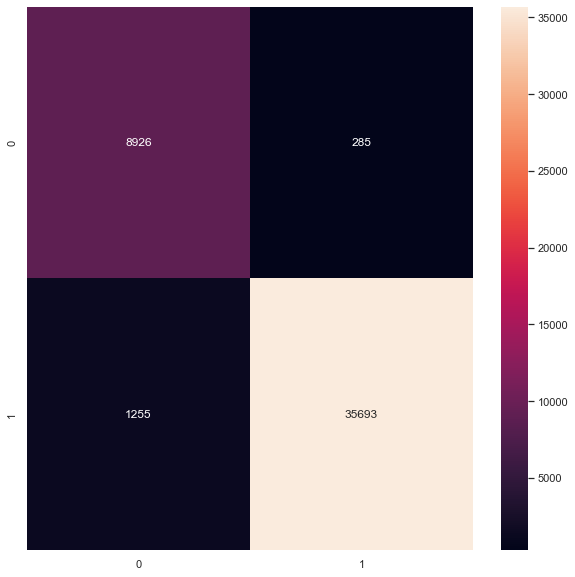

In [83]:
plt.figure(figsize=(10, 10))
sns.heatmap(conf, annot=True, fmt="g")
plt.show()